## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = 'Gel_Studies/11_09_18_gel_experiment' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 20
gels = ['0_4', '0_6', '0_8', '1_0', '1_2']
nonnum = ['Percent Agarose', 'Well', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
featofvar = 'Percent Agarose'

counter = 0
for gel in gels:
    for num in range(1, vids+1):
        try:
            filename = 'features_Gels_{}_XY{}.csv'.format(gel, '%02d' % num)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Percent Agarose'] = pd.Series(fstats.shape[0]*[gel], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            if num < 11:
                fstats['Well'] = pd.Series(fstats.shape[0]*[1], index=fstats.index)
            else:
                fstats['Well'] = pd.Series(fstats.shape[0]*[2], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        except:
            print('skip filename {}'.format(filename))

features_Gels_0_4_XY01.csv size: (3607, 67)
features_Gels_0_4_XY02.csv size: (3890, 67)
features_Gels_0_4_XY03.csv size: (4543, 67)
features_Gels_0_4_XY04.csv size: (4153, 67)
features_Gels_0_4_XY05.csv size: (4455, 67)
features_Gels_0_4_XY06.csv size: (4436, 67)
features_Gels_0_4_XY07.csv size: (4190, 67)
features_Gels_0_4_XY08.csv size: (4719, 67)
features_Gels_0_4_XY09.csv size: (5617, 67)
features_Gels_0_4_XY10.csv size: (7329, 67)
features_Gels_0_4_XY11.csv size: (3595, 67)
features_Gels_0_4_XY12.csv size: (3530, 67)
features_Gels_0_4_XY13.csv size: (4386, 67)
features_Gels_0_4_XY14.csv size: (5257, 67)
features_Gels_0_4_XY15.csv size: (6141, 67)
features_Gels_0_4_XY16.csv size: (4488, 67)
features_Gels_0_4_XY17.csv size: (5058, 67)
features_Gels_0_4_XY18.csv size: (3697, 67)
features_Gels_0_4_XY19.csv size: (3615, 67)
features_Gels_0_4_XY20.csv size: (3327, 67)
features_Gels_0_6_XY01.csv size: (4973, 67)
features_Gels_0_6_XY02.csv size: (0, 67)
features_Gels_0_6_XY03.csv size: (4

In [3]:
nonnum = ['Percent Agarose', 'Well', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins', 'index']

## Train-Test Split

In [4]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [5]:
# cols = fstats_tot.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [7]:
ncomp = 14
pca_train = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.199553510135394
1 component: 0.3172328541091254
2 component: 0.4055000590372462
3 component: 0.48183261781897535
4 component: 0.5334442128201459
5 component: 0.5817596262046598
6 component: 0.617918114803023
7 component: 0.6522538567363538
8 component: 0.6847057523491203
9 component: 0.7161752584288987
10 component: 0.7450645653049821
11 component: 0.7721272413613192
12 component: 0.7960492536193458
13 component: 0.8173593998514074


In [8]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

In [9]:
kmostat = pca.kmo(pca_train.scaled)

0.866949374316


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [10]:
import numpy as np
#ncomp = 16
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final['Percent Agarose']=='0_4'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final['Percent Agarose']=='0_6'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final['Percent Agarose']=='0_8'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final['Percent Agarose']=='1_0'].values[:, -ncomp:], axis=0)
dicti[4] = np.nanmean(pca_train.final[pca_train.final['Percent Agarose']=='1_2'].values[:, -ncomp:], axis=0)

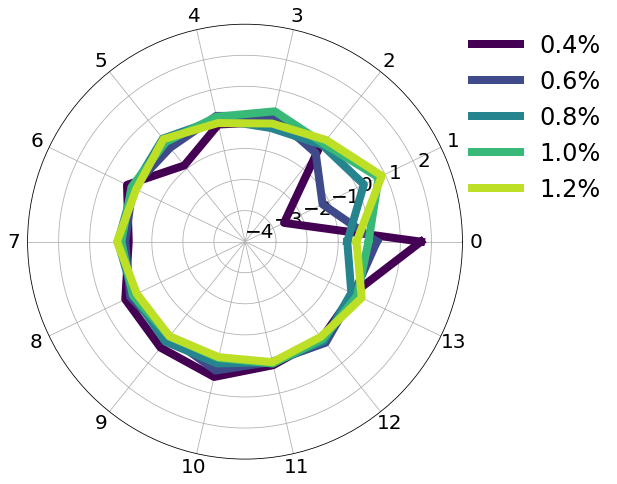

In [12]:
pca.plot_pca(dicti, savefig=True, labels=['0.4%', '0.6%', '0.8%', '1.0%', '1.2%'], rticks=np.linspace(-4, 2, 7))

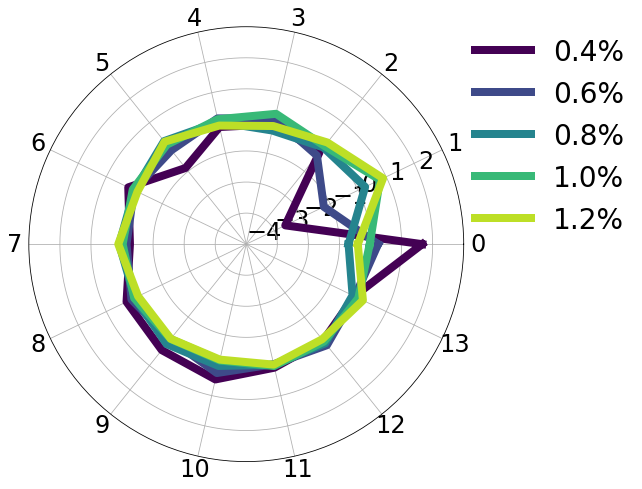

In [13]:
pca.plot_pca(dicti, savefig=True, labels=['0.4%', '0.6%', '0.8%', '1.0%', '1.2%'], rticks=np.linspace(-4, 2, 7), dpi=1200, labelsize=24,
             filename='pics/Fig2/gel_pcaavg.png')

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [15]:
pca_train.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Mean fractal_dim,Mean kurtosis,asymmetry2,Std asymmetry1,Std asymmetry2,Mean alpha,trappedness,D_fit,Std MSD_ratio,Std fractal_dim,Std Deff2,D_fit,Std MSD_ratio,Std alpha
1,Mean efficiency,Mean asymmetry3,asymmetry1,Std asymmetry2,Std asymmetry1,Mean D_fit,boundedness,straightness,Mean MSD_ratio,Std frames,Mean Deff2,kurtosis,Mean MSD_ratio,Mean alpha
2,Mean straightness,Std asymmetry3,asymmetry3,straightness,Std asymmetry3,Std D_fit,Mean MSD_ratio,frames,Std trappedness,Std kurtosis,kurtosis,Deff1,Std D_fit,Std D_fit
3,Mean asymmetry1,Mean elongation,elongation,Mean trappedness,trappedness,alpha,Std MSD_ratio,alpha,Std fractal_dim,Mean frames,Std kurtosis,Std kurtosis,Mean D_fit,Std kurtosis
4,Mean asymmetry2,Mean AR,trappedness,Mean boundedness,boundedness,D_fit,Std trappedness,boundedness,Std boundedness,Mean kurtosis,Deff1,frames,kurtosis,Mean kurtosis


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 5)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(loc='upper right', prop={'size': 15})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

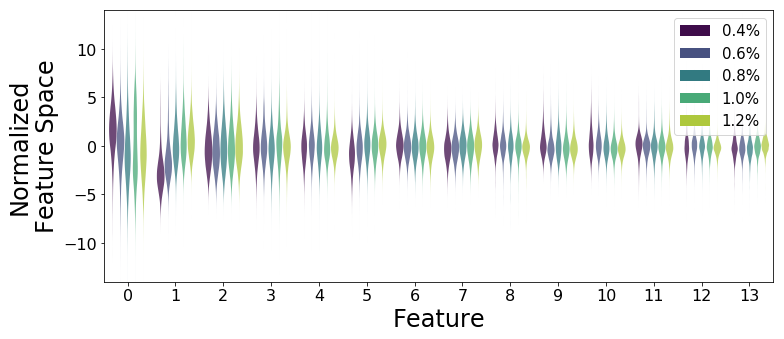

In [23]:
feats = feature_violin(pca_train.final, label='Percent Agarose', lvals=gels, labels=labels, fsubset=ncomp, yrange=[-14, 14],
                       legendfontsize=18, labelsize=24, fname='./pics/Fig2/gels_pcadist.png')

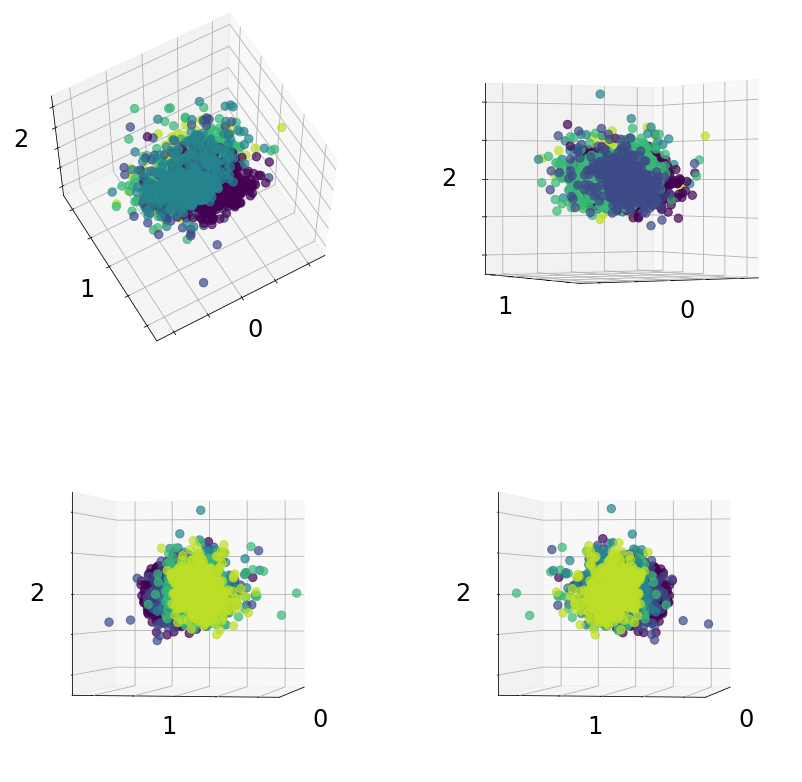

In [29]:
fstats1 = pca.feature_plot_3D(pca_train.final, label='Percent Agarose', lvals=gels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              filename='./pics/Fig2/gels_3feats.png')

## Neural Network

In [30]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [31]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.98224941
Validation score: 0.631905
Iteration 2, loss = 0.90889109
Validation score: 0.645472
Iteration 3, loss = 0.87445643
Validation score: 0.656726
Iteration 4, loss = 0.84475903
Validation score: 0.662353
Iteration 5, loss = 0.81711270
Validation score: 0.677889
Iteration 6, loss = 0.79124283
Validation score: 0.687643
Iteration 7, loss = 0.76813926
Validation score: 0.704836
Iteration 8, loss = 0.74809178
Validation score: 0.703617
Iteration 9, loss = 0.72932534
Validation score: 0.717497
Iteration 10, loss = 0.71368305
Validation score: 0.720341
Iteration 11, loss = 0.69641008
Validation score: 0.741224
Iteration 12, loss = 0.68382779
Validation score: 0.745756
Iteration 13, loss = 0.67199666
Validation score: 0.752571
Iteration 14, loss = 0.66532539
Validation score: 0.748789
Iteration 15, loss = 0.65756114
Validation score: 0.756385
Iteration 16, loss = 0.64838575
Validation score: 0.757635
Iteration 17, loss = 0.64138102
Validation score: 0.753103
Iterat

In [33]:
X_train = pca_train.final[pca_train.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])].values[:, -ncomp:]
X_test = pca_test.final[pca_test.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])].values[:, -ncomp:]
y_train = pca_train.final[pca_train.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])][featofvar].values
y_test = pca_test.final[pca_test.final['Percent Agarose'].isin(['0_4', '0_8', '1_2'])][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.46988320
Validation score: 0.826315
Iteration 2, loss = 0.41224487
Validation score: 0.844870
Iteration 3, loss = 0.38952672
Validation score: 0.848516
Iteration 4, loss = 0.37082455
Validation score: 0.858986
Iteration 5, loss = 0.35344272
Validation score: 0.863893
Iteration 6, loss = 0.33599015
Validation score: 0.878757
Iteration 7, loss = 0.32072210
Validation score: 0.867913
Iteration 8, loss = 0.30441067
Validation score: 0.854873
Iteration 9, loss = 0.29157627
Validation score: 0.891750
Iteration 10, loss = 0.27720580
Validation score: 0.891704
Iteration 11, loss = 0.26504126
Validation score: 0.884272
Iteration 12, loss = 0.25566145
Validation score: 0.907221
Iteration 13, loss = 0.24294773
Validation score: 0.906100
Iteration 14, loss = 0.23554185
Validation score: 0.872494
Iteration 15, loss = 0.22834569
Validation score: 0.917364
Iteration 16, loss = 0.21736472
Validation score: 0.828652
Iteration 17, loss = 0.21338734
Validation score: 0.753120
Iterat